In [333]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [154]:
datetime_cols = ["eta", "ata", "atd", "earliesteta", "latesteta"]
data = pd.read_csv("VesselData.csv", parse_dates=datetime_cols)

In [155]:
data.columns

Index(['eta', 'ata', 'atd', 'vesseldwt', 'vesseltype', 'discharge1', 'load1',
       'discharge2', 'load2', 'discharge3', 'load3', 'discharge4', 'load4',
       'stevedorenames', 'hasnohamis', 'earliesteta', 'latesteta',
       'traveltype', 'previousportid', 'nextportid', 'isremarkable',
       'vesselid'],
      dtype='object')

In [156]:
# no values at all for hasnohamis, so let's drop it
data["hasnohamis"].unique()

array([nan])

In [157]:
# all values of isremarkable are the same, so let's drop it
data["isremarkable"].unique()

array(['f'], dtype=object)

In [158]:
data = data.drop(columns=["hasnohamis", "isremarkable"])

In [168]:
# create useful time vars, both measured in days
SECONDS_PER_DAY = 86400
data["arrival_error"] = [timedelt.total_seconds()/SECONDS_PER_DAY for timedelt in data["ata"] - data["eta"]]
data["time_at_port"] = [timedelt.total_seconds()/SECONDS_PER_DAY for timedelt in data["atd"] - data["ata"]]
data[["arrival_error", "time_at_port"]]

,arrival_error,time_at_port
0,0.0,3.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,0.0
...,...,...
8203,0.0,1.0
8204,0.0,2.0
8205,-1.0,4.0
8206,0.0,0.0


In [159]:
# create sum of all discharge and load vars
transships_vars = {"trans1": ['discharge1', 'load1'],
                   "trans2": ['discharge2', 'load2'], 
                   "trans3": ['discharge3', 'load3'],
                   "trans4": ['discharge4', 'load4']}
for k,vals in transships_vars.items():
    data[k] = sum([data[v] for v in vals])


var 1 percent nonzero: 0.021564327485380116
var 2 percent nonzero: 0.016203703703703703
var 3 percent nonzero: 0.04690545808966862
var 4 percent nonzero: 0.11269493177387914


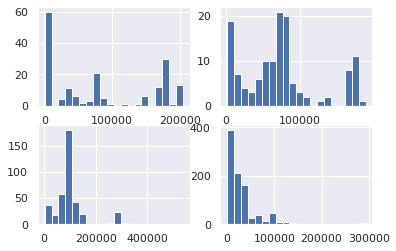

In [160]:
# look at each var of interest
fig, axs = plt.subplots(2,2)
for i, ax in zip(range(1,5), axs.flatten()):
    var = f"trans{i}"
    # only look at when data != 0
    to_plot = data[data[var] != 0][var]
    print(f"var {i} percent nonzero: {len(to_plot) / len(data)}")
    ax.hist(to_plot, bins=20)

In [177]:
# we see that almost all of the data is 0 for each cargo type. Let's
# create masks for whether each ship has any cargo of that type
for i in range(1,5):
    data[f"has_trans{i}"] = data[f"trans{i}"] != 0

# check for trans3, looks good
data[["has_trans3", "trans3"]]

,has_trans3,trans3
0,True,90173
1,False,0
2,False,0
3,False,0
4,False,0
...,...,...
8203,False,0
8204,False,0
8205,False,0
8206,False,0


In [191]:
data.columns

Index(['eta', 'ata', 'atd', 'vesseldwt', 'vesseltype', 'discharge1', 'load1',
       'discharge2', 'load2', 'discharge3', 'load3', 'discharge4', 'load4',
       'stevedorenames', 'earliesteta', 'latesteta', 'traveltype',
       'previousportid', 'nextportid', 'vesselid', 'trans1', 'trans2',
       'trans3', 'trans4', 'arrival_error', 'time_at_port', 'has_trans1',
       'has_trans2', 'has_trans3', 'has_trans4'],
      dtype='object')

In [319]:
X_cols = ["vesseldwt", "vesseltype", "traveltype", "arrival_error", "time_at_port"]
Y_cols = ["trans1", "trans2", "trans3", "trans4", 
          "has_trans1", "has_trans2", "has_trans3", "has_trans4"]
X = data[X_cols]
Y = data[Y_cols]

In [361]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [362]:
# only cargo types 3 and 4 overlap in very few cases, 
# so let's sacrafice these errors and just build a classifier
# to determine what type of cargo a ship has
cargo_types = [1,2,3,4]
for i in cargo_types:
    print(Y_train[Y_train[f"has_trans{i}"] == True][[f"has_trans{j}" for j in cargo_types if j != i]].sum())

has_trans2    0
has_trans3    0
has_trans4    0
dtype: int64
has_trans1    0
has_trans3    0
has_trans4    0
dtype: int64
has_trans1    0
has_trans2    0
has_trans4    6
dtype: int64
has_trans1    0
has_trans2    0
has_trans3    6
dtype: int64


In [363]:
# drop the disagreeing rows
bad_idxs = Y_train.query("has_trans3==True & has_trans4==True").index
X_train = X_train.drop(index=bad_idxs)
Y_train = Y_train.drop(index=bad_idxs)

In [364]:
# 1--4 for those cargo types, 0 for no cargo
def determine_cargo_class(has_trans_row):
    if has_trans_row["has_trans1"] == True:
        return 1
    elif has_trans_row["has_trans2"] == True:
        return 2
    elif has_trans_row["has_trans3"] == True:
        return 3
    elif has_trans_row["has_trans4"] == True:
        return 4
    else:
        return 0

In [365]:
def transform_X(X):
    X = X.copy()
    travel_ints = []
    for idx, row in X.iterrows():
        if row["traveltype"] == "SHIFT":
            travel_ints.append(0)
        else:
            travel_ints.append(1)
    X["traveltype"] = travel_ints
    return X

In [366]:
def transform_Y(Y):
    Y = Y.copy()
    cargo_classes = []
    for idx, row in Y.iterrows():
        cargo_classes.append(determine_cargo_class(row))
    Y["cargo_class"] = cargo_classes
    return Y

In [367]:
na_X_idx = X_train[X_train.isnull().any(axis=1)].index
X_train = X_train.drop(index=na_X_idx)
Y_train = Y_train.drop(index=na_X_idx)

X_train = transform_X(X_train)
Y_train = transform_Y(Y_train)

cargo_encoder = OneHotEncoder()
cargo_type_train = cargo_encoder.fit_transform(Y_train[["cargo_class"]])

cargo_type_clf = RandomForestClassifier(n_estimators=100)
cargo_type_clf.fit(X_train, Y_train["cargo_class"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [368]:
X_test = transform_X(X_test)
Y_test = transform_Y(Y_test)

# so we do an ok job predicting the type of cargo on the ship, overall f1-score of 0.89
print(classification_report(Y_test["cargo_class"], cargo_type_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2160
           1       0.62      0.43      0.51        65
           2       0.60      0.56      0.58        50
           3       0.92      0.75      0.82       130
           4       0.66      0.65      0.66       304

    accuracy                           0.89      2709
   macro avg       0.75      0.67      0.70      2709
weighted avg       0.89      0.89      0.89      2709



In [370]:
# now we need to predict the amount of cargo
data.columns

Index(['eta', 'ata', 'atd', 'vesseldwt', 'vesseltype', 'discharge1', 'load1',
       'discharge2', 'load2', 'discharge3', 'load3', 'discharge4', 'load4',
       'stevedorenames', 'earliesteta', 'latesteta', 'traveltype',
       'previousportid', 'nextportid', 'vesselid', 'trans1', 'trans2',
       'trans3', 'trans4', 'arrival_error', 'time_at_port', 'has_trans1',
       'has_trans2', 'has_trans3', 'has_trans4'],
      dtype='object')

In [373]:
weight_X_train = X_train
weight_X_train["cargo_class"] = Y_train["cargo_class"]

In [376]:
Y_train["total_trans"] = 

,trans1,trans2,trans3,trans4,has_trans1,has_trans2,has_trans3,has_trans4,cargo_class
2908,0,0,0,0,False,False,False,False,0
3459,0,0,0,0,False,False,False,False,0
272,0,0,0,0,False,False,False,False,0
2042,0,0,0,0,False,False,False,False,0
7448,0,0,0,0,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...
5734,0,0,0,0,False,False,False,False,0
5191,0,0,0,0,False,False,False,False,0
5390,0,0,0,0,False,False,False,False,0
860,0,0,0,0,False,False,False,False,0
